# Exploring EEG data

(0, 33)

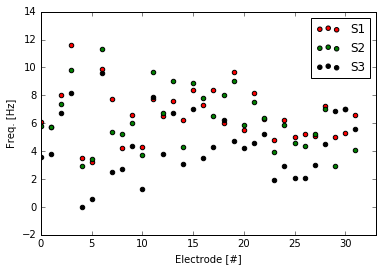

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
plt.style.use('classic')
%matplotlib inline

df = pd.read_csv('some_data.csv',index_col=0)
subjects = df.index
electrodes = df.columns
cs = ['r','g','k','b','gray']

for i, s in enumerate(subjects):
    plt.scatter(range(0,len(electrodes)),df.iloc[i,:],c=cs[i],label=f'S{i+1}')
    if i==2:
        break
        
plt.xlabel('Electrode [#]')
plt.ylabel('Freq. [Hz]')
plt.legend()
plt.xlim(0,33)

## Balagan! 
### Our goal here is to find groups of electrodes (out of the 32), which might share similar properties. This could indicate the right anatomical area for future intervension.
## So first, let's reduce dimensions - how many dimensions (=electrodes) are needed to explain most of the variance in our experiment

Total variance explained: 100.0%
-by 5 PCs we exlain: 64.6%


Text(0, 0.5, 'PC2 [13.24%]')

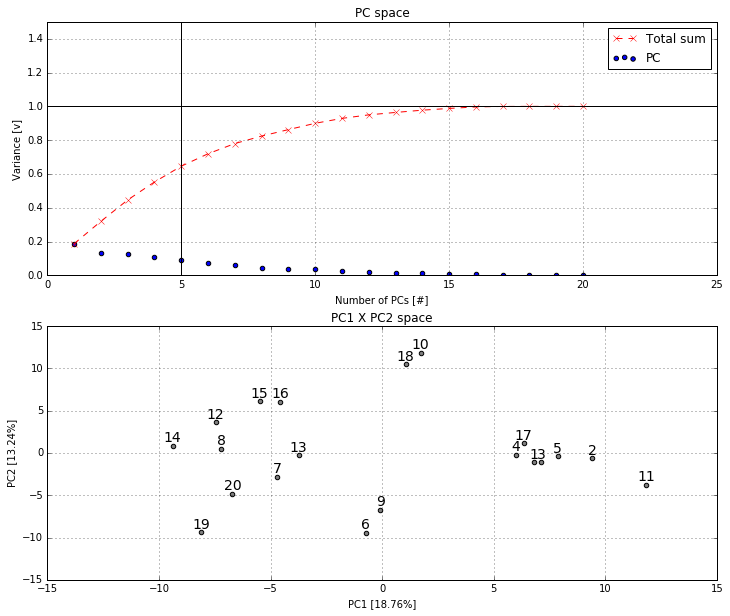

In [2]:
pca = PCA()
pca.fit(df)

#how mach variance was explained by each PC
var = pca.explained_variance_ratio_
print(f'Total variance explained: {100*var.sum():.1f}%') #note that the total variance should sum to 1

fig, ax = plt.subplots(figsize=(12,10), nrows=2, ncols=1)
ax[0].set_title('PC space')
ax[0].scatter(range(1,len(var)+1),var,label='PC')
ax[0].plot(range(1,len(var)+1),var.cumsum(), marker = 'x', c='r', linestyle='--',label='Total sum')
ax[0].axhline(y=1,c='k')
ax[0].set_xlabel('Number of PCs [#]')
ax[0].set_ylabel('Variance [v]')
ax[0].set_ylim(0,1.5)
ax[0].grid()
ax[0].legend()
ax[0].axvline(x=5,c='k')

x=5
print(f'-by {x} PCs we exlain: {100*var[0:x].cumsum()[x-1]:.1f}%')
ax[1].set_title('PC1 X PC2 space')
pca = PCA(n_components=2)
pca.fit(df)
df_pca = pca.transform(df)
ax[1].scatter(df_pca[:,0],df_pca[:,1],c='gray')
ax[1].grid()
for i,n in enumerate(subjects):
    ax[1].annotate(n,(df_pca[i,0],df_pca[i,1]),fontsize=14, xytext=(0,1), 
        textcoords='offset points', ha='center', va='bottom', color='k')
ax[1].set_xlabel(f'PC1 [{100*var[0]:.2f}%]')
ax[1].set_ylabel(f'PC2 [{100*var[1]:.2f}%]')


## Next, we test how many groups of subjects can describe our PC results (e.g., healthy, PD patients, AD patients etc.). This can be done by K-means, testing how many clusters are a good fit for the reduced data (in PC space)

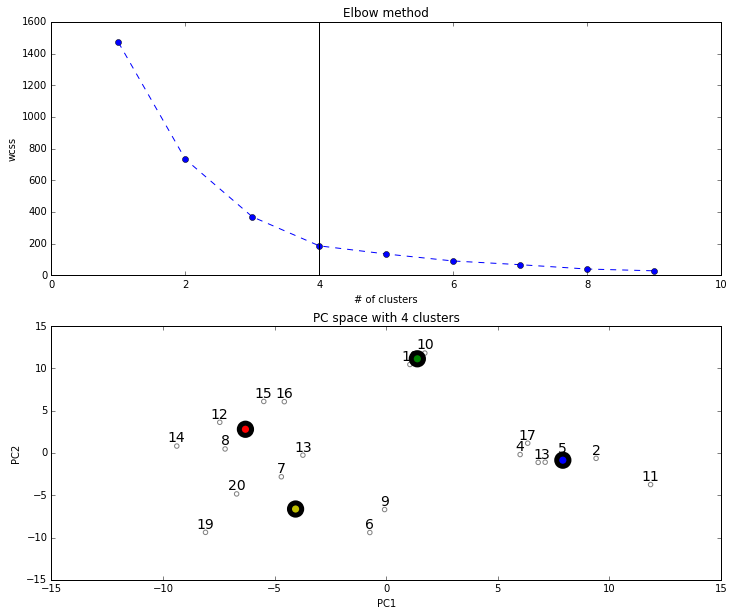

In [3]:
from sklearn.cluster import KMeans
fig, ax = plt.subplots(figsize=(12,10), nrows=2, ncols=1)
wcss = []
centroids=[]
ks=10

g = 4
for i in range(1,ks):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)
    if i==g:
        centroids  = kmeans.cluster_centers_
        centroids_x = centroids[:,0]
        centroids_y = centroids[:,1]
        ax[1].scatter(centroids_x,centroids_y,marker = "o", s=150,linewidths = 5, zorder = 10,c=['b','r','y','g'])
        ax[1].scatter(df_pca[:,0],df_pca[:,1], facecolors='none', edgecolors='gray')
        ax[1].set_xlabel('PC1')
        ax[1].set_ylabel('PC2')
        ax[1].set_title(f'PC space with {i} clusters')      
        for j,n in enumerate(subjects):
            ax[1].annotate(n,(df_pca[j,0],df_pca[j,1]),fontsize=14, xytext=(0,1), 
                textcoords='offset points', ha='center', va='bottom', color='k')
        
ax[0].plot(range(1,ks), wcss, marker='o', linestyle='--')
ax[0].set_xlabel('# of clusters')
ax[0].set_ylabel('wcss')
ax[0].set_title('Elbow method')
ax[0].set_xlim(0,ks)
ax[0].axvline(x=g,c='k')


Text(0.5, 1.0, 'Maximum Distances Hierarchy')

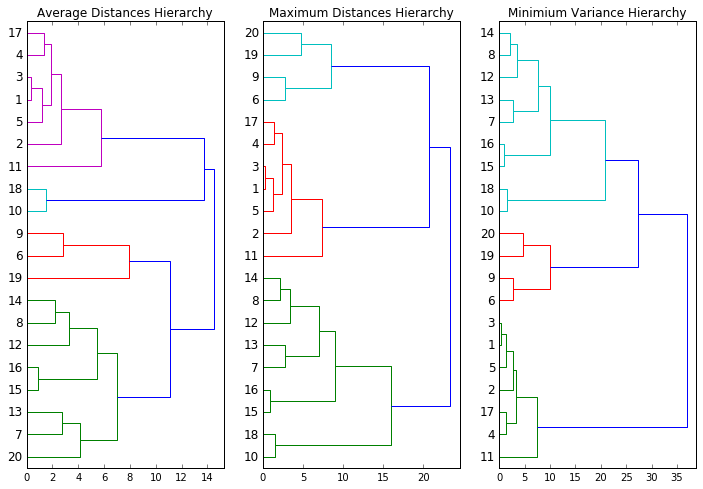

In [16]:
import scipy.cluster.hierarchy as shc

methods = ['average','complete','ward']
exp = ['Average Distances','Maximum Distances','Minimium Variance']
fig, axes = plt.subplots(figsize=(12,8), nrows=1, ncols=3)

# Iterate over different linkage criteria 
for i,m in enumerate(methods):
    dend1 = shc.dendrogram(shc.linkage(df_pca, method=m), labels=subjects , orientation='right',ax=axes[i])
    axes[i].title.set_text(f'{exp[i]} Hierarchy')
axes[1].set_title(f'{exp[1]} Hierarchy')
